# **Reinforcement Learning: Tarea 1, Estudio comparativo de algoritmos en un problema de k-armed bandit**

## **Autores:** Ana Gil Molina, José María García Ortiz y Levi Malest Villarreal

<br>

**Description:** En esta notebook realizaremos un experimento sobre el *problema del bandido de k brazos* con el que pretendemos comparar el desempeño de distintos algoritmos de la familia *$\varepsilon$-greedy* en base a estadísticos como el porcentaje de elecciones de brazo óptimas, el promedio de *ganancias* por brazo y el *regret* acumulado en función del tiempo.

Para poder interpretar los resultados, se incluyen unas gráficas con sus respectivos análisis y conclusiones al final de la sección **[2]** y en la sección **[3].**

<br>

*This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.*

*For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html*



## **[1] - Preparación del entorno**


In [ ]:
#@title Copiar el repositorio ``JMGO-coding/k_brazos_GGM``.

!git clone https://github.com/JMGO-coding/k_brazos_GGM.git
!cd k_brazos_GGM/

Cloning into 'k_brazos_GGM'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (159/159), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 314 (delta 92), reused 1 (delta 1), pack-reused 155 (from 1)
Receiving objects: 100% (314/314), 1013.05 KiB | 3.79 MiB/s, done.
Resolving deltas: 100% (148/148), done.


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_GGM')
sys.path.append('/content/k_brazos_GGM/src')



# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List

#from src.algorithms import Algorithm, EpsilonGreedy
#from src.arms import ArmNormal, Bandit
#from src.plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret


from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/usr/local/lib/python3.11/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/k_brazos_GGM', '/content/k_brazos_GGM/src']


## **[2] - Experimento**

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [ ]:
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):
    """
    Ejecuta experimentos comparativos entre diferentes algoritmos.

    :param bandit: Instancia de Bandit configurada para el experimento.
    :param algorithms: Lista de instancias de algoritmos a comparar.
    :param steps: Número de pasos de tiempo por ejecución.
    :param runs: Número de ejecuciones independientes.
    :return: Tuple de tres elementos: recompensas promedio, porcentaje de selecciones óptimas, y estadísticas de brazos.
    :rtype: Tuple of (np.ndarray, np.ndarray, list)
    """

    k = bandit.k
    optimal_arm = bandit.optimal_arm

    # Inicializar matrices para recompensas y selecciones óptimas
    rewards = np.zeros((len(algorithms), steps))
    optimal_selections = np.zeros((len(algorithms), steps))

    # Inicializar el regret global acumulado por cada algoritmo
    global_cumulative_regret_per_algo = np.zeros((len(algorithms),steps))

    for run in range(runs):
        # Crear una nueva instancia del bandit para cada ejecución
        current_bandit = Bandit(arms=bandit.arms)

        # Obtener la recompensa esperada óptima
        q_max = current_bandit.get_expected_value(current_bandit.optimal_arm)

        for algo in algorithms:
            algo.reset()

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        total_rewards_per_algo = np.zeros(len(algorithms))  # Para análisis por rechazo

        # Inicializar recompensas acumuladas por algoritmo para esta ejecución
        # cumulative_rewards_per_algo = np.zeros(len(algorithms))

        num_choices_list = [[0 for _ in range(len(current_bandit.arms))] for _ in algorithms]   # para almacenar un conteo de las selecciones de cada brazo del bandido para cada algoritmo

        rewards_per_arm = np.zeros((len(algorithms), len(current_bandit.arms)))    # para almacenar las recompensas por cada brazo

        # Ejecutar cada algoritmo
        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm()
                reward = current_bandit.pull_arm(chosen_arm)
                algo.update(chosen_arm, reward)

                num_choices_list[idx][chosen_arm] += 1   # Actualizamos el conteo del brazo seleccionado en la estapa correspondiente del algoritmo ``algo``

                rewards[idx, step] += reward
                total_rewards_per_algo[idx] += reward

                rewards_per_arm[idx][chosen_arm] += reward

                global_cumulative_regret_per_algo[idx, step] = q_max*step - total_rewards_per_algo[idx]    # Actualziamos el regret acumulado en cada paso de decisión para cada algoritmo

                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

    # Promediar las recompensas y el regret sobre todas las ejecuciones
    rewards /= runs
    optimal_selections = (optimal_selections / runs) * 100
    proportional_cumulative_regret_per_algo = global_cumulative_regret_per_algo.copy()
    proportional_cumulative_regret_per_algo /= runs
    rewards_per_arm /= runs

    return rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm

### Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 8 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4 y 0.7.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10        # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500    # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k))    # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.05), EpsilonGreedy(k=k, epsilon=0.1),
              EpsilonGreedy(k=k, epsilon=0.2), EpsilonGreedy(k=k, epsilon=0.3), EpsilonGreedy(k=k, epsilon=0.4), EpsilonGreedy(k=k, epsilon=0.7)]

# Extras
optimal_arms_list = [optimal_arm for _ in range(len(algorithms))]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, num_choices_list, proportional_cumulative_regret_per_algo, rewards_per_arm = run_experiment(bandit, algorithms, steps, runs)

# Estadísticas de cada brazo
arm_stats = [{arm: {"media": arm.mu, "std": arm.sigma} for arm in bandit.arms} for _ in range(len(algorithms))]

# Agregar la recompensa por brazo de cada algoritmo en el diccionario correspondiente
for algo_idx in range(len(algorithms)):  # Para cada algoritmo
    for arm_idx, arm in enumerate(bandit.arms):  # Para cada brazo del bandido
        arm_stats[algo_idx][arm]["reward"] = rewards_per_arm[algo_idx][arm_idx]  # Añadir el reward

Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


### Visualización de los resultados

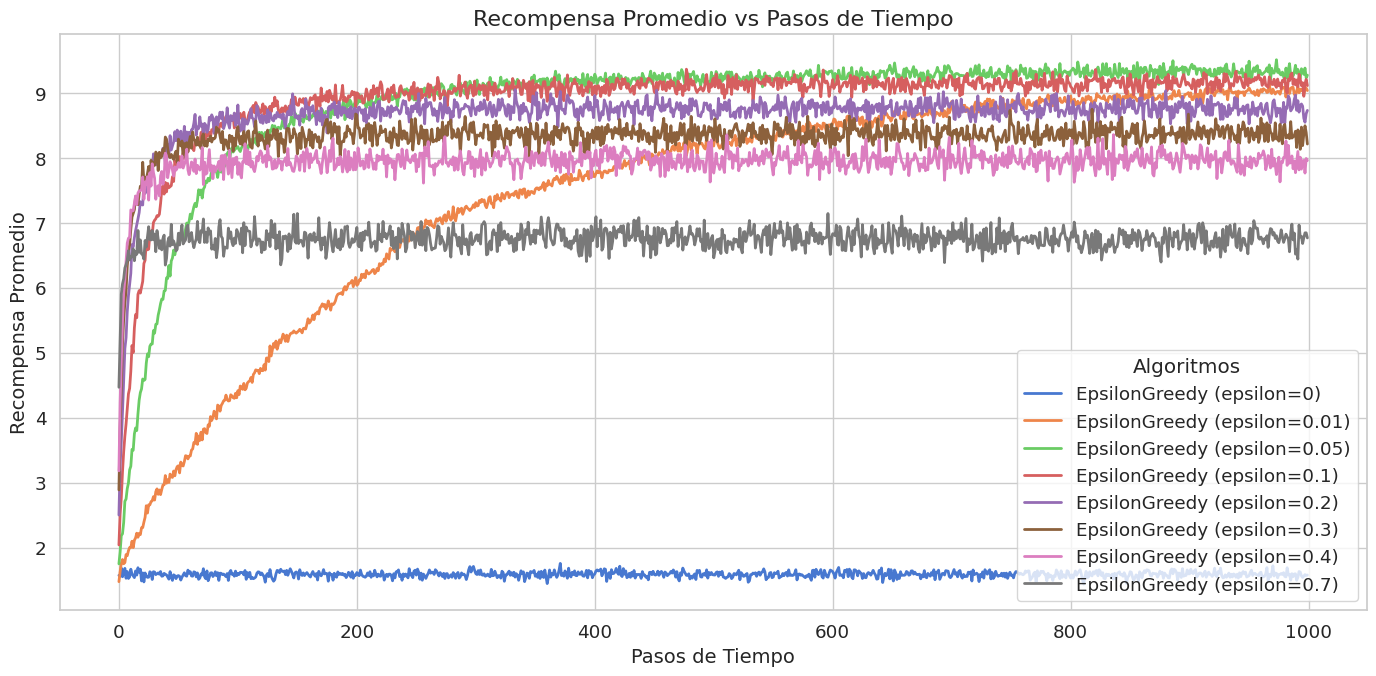

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

### Análisis detallado de la imagen

La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Ocho líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.05):** Representa una estrategia con una probabilidad del 5% de elegir una acción aleatoria (exploración).
   - **Rojo (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.
   - **Morado (ε = 0.2):** Representa una estrategia con un 20% de probabilidad de explorar acciones aleatorias.
   - **Marrón (ε = 0.3):** Representa una estrategia con un 30% de probabilidad de explorar acciones aleatorias.
   - **Rosa (ε = 0.4):** Representa una estrategia con un 40% de probabilidad de explorar acciones aleatorias.
   - **Gris (ε = 0.7):** Representa una estrategia con un 70% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.
   - La línea **naranja (ε=0.01)** muestra un cierto crecimiento, pero más lento en comparación con ε=0.05 y ε=0.1.
   - La línea **verde (ε=0.05)** también muestra un crecimiento, algo lento al principio, pero que con el paso del tiempo logra superar a ε=0.1.
   - La línea **roja (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **morada (ε=0.2)** crece muy rápidamente al principio, incluso más rápido que con ε=0.1, pero ese crecimiento se detiene en un valor inferior al que se lograba alcanzar en el caso anterior. Esto indica que una mayor exploración es beneficiosa al inicio del experimento, pues se logra encontrar el brazo óptimo más rápidamente, pero una vez se ha encontrado dicho brazo, una mayor exploración puede perjudicar a la larga, ya que de esta manera no se centra tanto en explotar el mejor brazo.
   - La línea **marrón (ε=0.3)** también crece muy rápidamente al principio, pero ese crecimiento se detiene en un valor todavía inferior al alcanzado con ε=0.2.
   - La línea **rosa (ε=0.4)** de nuevo crece muy rápidamente al principio, pero deteniéndose en un valor todavía inferior al alcanzado con ε=0.3. Además, se observa una mayor oscilación de la recompensa promedio, probablemente debido a que una vez encontrado el brazo óptimo, se sigue explorando en un 40% de los pasos, lo cual ya no es necesario, y perjudica a los resultados.
   - La línea **gris (ε=0.7)** crece muy rápido pero se detiene en un valor muy inferior a los alcanzados en los casos anteriores. Mostrando además una gran oscilación de la recompensa promedio, probablemente debido a que una vez encontrado el brazo óptimo, se sigue explorando en un 70% de los pasos, lo cual es muy ineficiente e innecesario.
---





## **[3] - Otros análisis gráficos y conclusiones**

<br>

Hemos estudiado un  **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

<br>

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

El gráfico confirma este comportamiento:
- **ε=0.2 (morado)**, **ε=0.3 (marrón)**, **ε=0.4 (rosa)** y **ε=0.7 (gris)** muestran un desempeño cada vez peor, ya que exploran demasiado, de forma que encuentran rápidamente el brazo óptimo, pero una vez lo encuentran, siguen explorando demasiadas veces brazos subóptimos, en lugar de centrarse en explotar el brazo óptimo.
- **ε=0.05 (verde)** y **ε=0.1 (rojo)** obtienen las mejores recompensas promedio a lo largo del tiempo porque exploran lo suficiente como para encontrar rápidamente el mejor brazo.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima.

<br>

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1, ε=0.2, ε=0.3, ε=0.4, ε=0.7) alcanzan una recompensa alta más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.

<br>

#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.05** o **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

<br>

En conclusión, **el gráfico muestra cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀

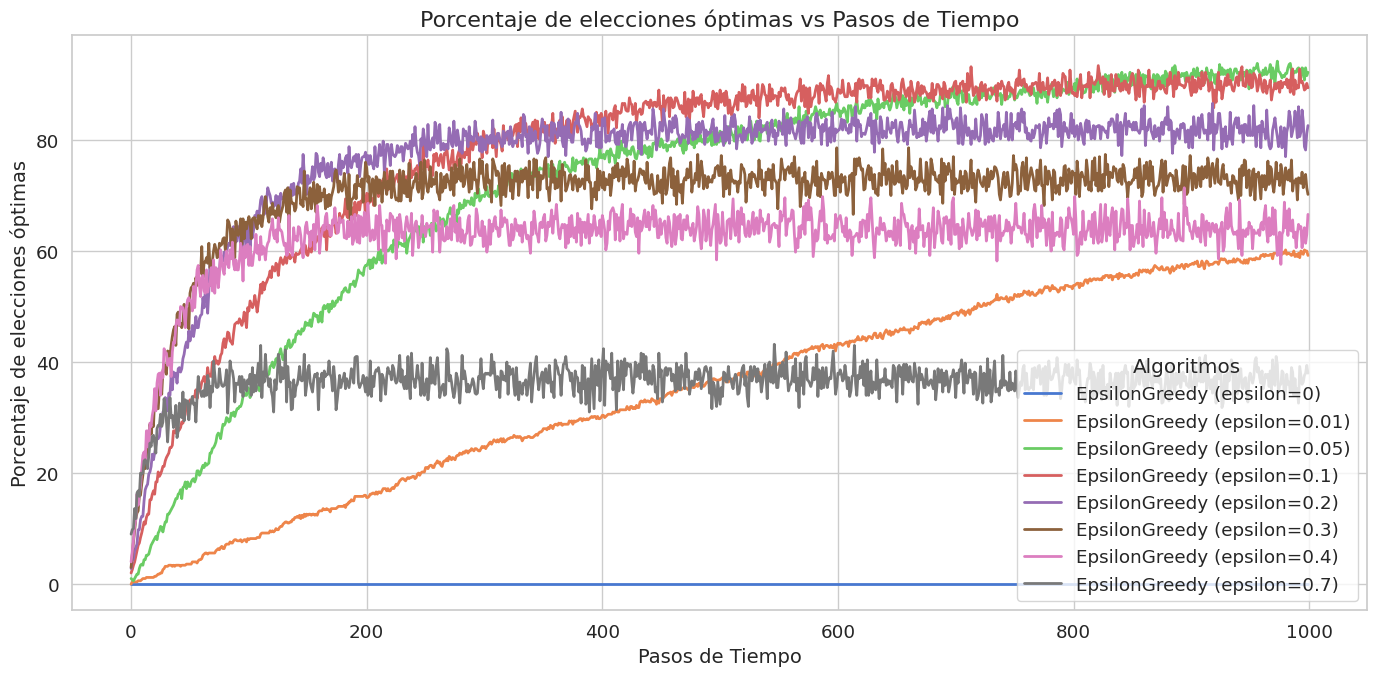

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

### Análisis detallado de la imagen

Esta segunda imagen muestra un gráfico de líneas titulado **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, donde se vuelve a analizar el desempeño de las diferentes estrategias del algoritmo **ε-Greedy** consideradas en un entorno de multi-armed bandit. En este caso, en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **porcentaje de elecciones óptimas** obtenido por cada algoritmo.

**Crecimiento del porcentaje de elecciones óptimas:**
  - El algoritmo con **ε=0** (línea **azul**) no explora, de forma que su porcentaje de elecciones óptimas se mantiene en un nivel bajo, ya que no consigue encontrar el mejor brazo, quedándose atrapado en una mala primera elección sin corregirla.
  - El algoritmo con **ε=0.01** (línea **naranja**) explora en un $1\%$ de los casos, de forma que consigue encontrar brazos mejores a lo largo del tiempo. A pesar de esto, el crecimiento del porcentaje de elecciones óptimas es algo lento.
  - El algoritmo con **ε=0.05** (línea **verde**) explora en un $5\%$ de los casos. En este caso, el crecimiento del porcentaje de elecciones óptimas es más rápido, aunque otros valores lo son todavía más. Sin embargo, observamos que con el paso del tiempo, sigue aumentando y finalmente consigue superar a todos los demás algoritmos.
  - El algoritmo con **ε=0.1** (línea **roja**) alcanza rápidamente un porcentaje de elecciones óptimas alto, lo que de nuevo indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos. Además, se estabiliza al alcanzar un porcentaje elevado de elecciones óptimas.
  - El algoritmo con **ε=0.2** (línea **morada**) alcanza más rápidamente un porcentaje de elecciones óptimas alto, pues al realizar una mayor exploración, encuentra antes el brazo óptimo. Sin embargo, se estabiliza al alcanzar un porcentaje de elecciones óptimas algo menor que en el caso de ε=0.1.
  - El algoritmo con **ε=0.3** (línea **marrón**) crece todavía más rápido al principio al realizar una mayor exploración. Sin embargo, no llega a crecer tanto como en los casos anteriores.
  - El algoritmo con **ε=0.4** (línea **rosa**) también crece bastante rápido al principio, pero en poco tiempo deja de crecer, y se estabiliza en un valor más bajo que los algoritmos anteriores, debido a que explora demasiado.
  - El algoritmo con **ε=0.7** (línea **gris**) crece rápido al principio, pero en muy poco tiempo deja de crecer, y se estabiliza en un valor considerablemente más bajo que los algoritmos anteriores, pues explora demasiado o no explota lo suficiente el brazo óptimo. Además, se observa que el porcentaje de elecciones óptimas oscila mucho.

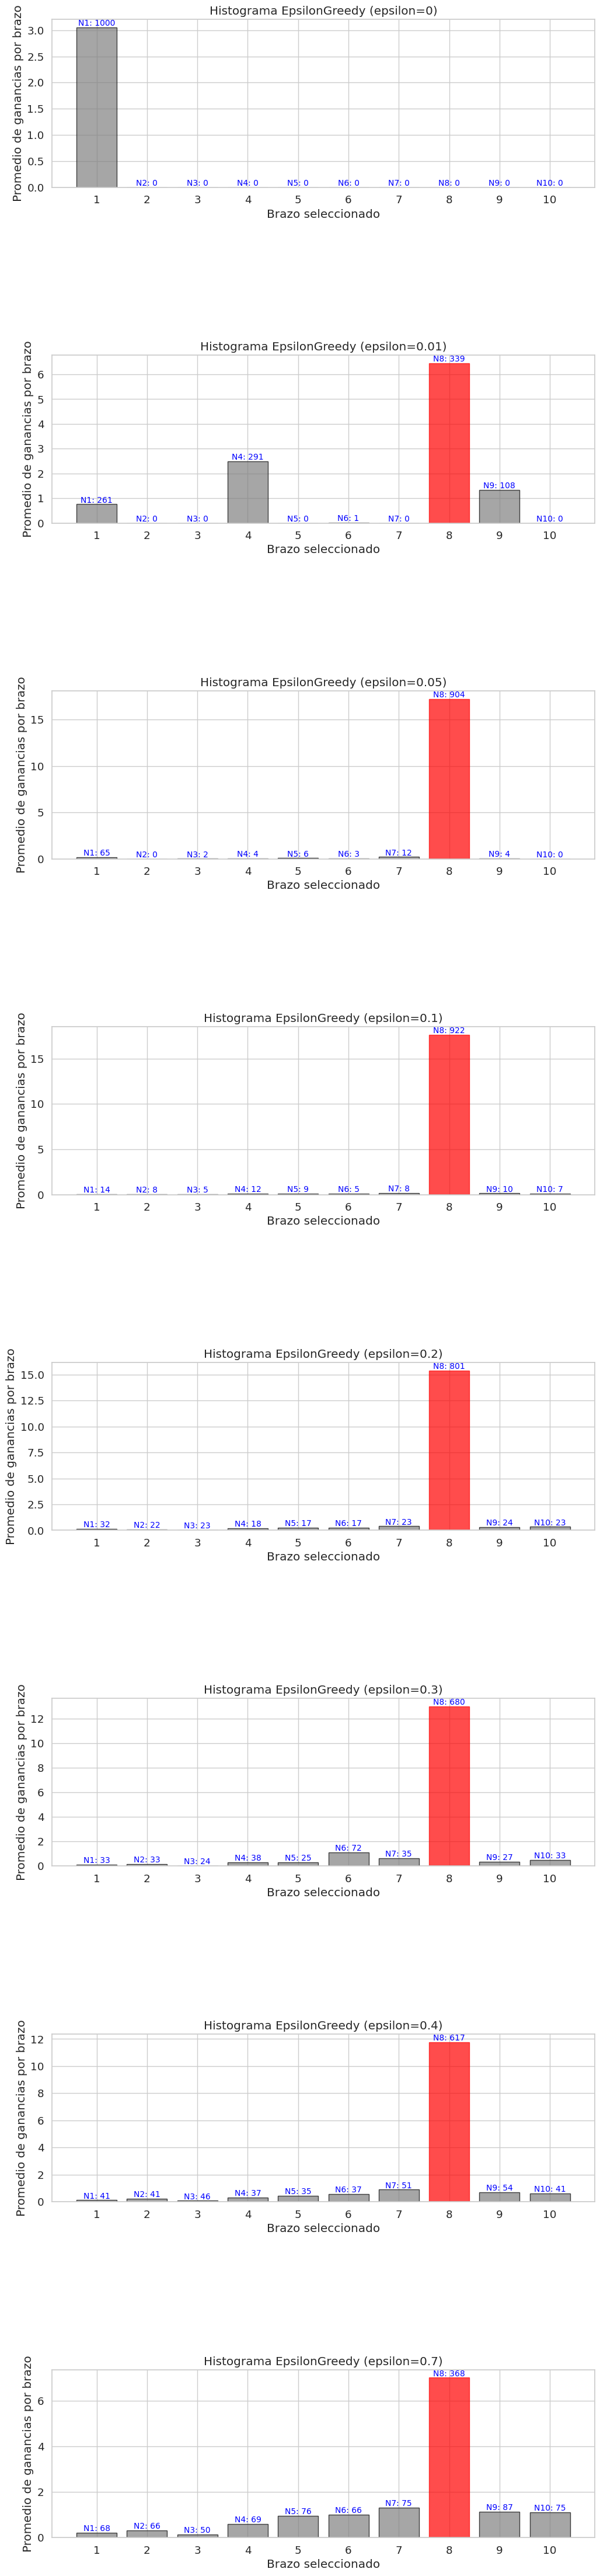

In [ ]:
plot_arm_statistics(arm_stats, algorithms, optimal_arms_list, num_choices_list)

### Análisis detallado de la imagen

<br>

El plot anterior contiene 8 gráficos de barras, uno para cada algoritmo del estudio, en los que se muestra la recompensa promedio de cada brazo tras las 1000 ejecuciones de cada algoritmo (recompensa total asociada al brazo $i$ en el algoritmo $m$ entre el número de iteraciones $n$)
$$ \overline{r}_{i,m} \hspace{0.1 cm} := \hspace{0.1 cm} \frac{\hat{r}_{i, m, n}}{n}$$

Además, sobre cada barra de los gráficos encontramos en color azul una expresión del tipo

$$Ni: \hspace{0.1 cm} z$$

indicando que el $i$-ésimo brazo del bandido ha sido seleccionado $z$ veces a lo largo de todas las ejecuciones del experimento con el algoritmo en cuestión.También, el brazo óptimo de cada bandido (siempre es el octavo, ya que el bandido no varía al cambiar de algoritmo en el experimento) tiene coloreada en rojo su barra asociada para diferenciarlo de los demás, ya que el análisis de estas gráficas gira en torno al número de elecciones del brazo óptimo y las distintas recompensas de cada brazo en según qué algoritmo.

<br>

- En la primera de las gráficas **($\varepsilon$ = 0)** observamos que se selecciona 1000 veces el brazo número 1 y 0 los demás. Esto se debe a que no hay exploración alguna en ninguna de las etapas de este algoritmo $\varepsilon$-greedy. Lo que ocurre es que se selecciona un brazo al azar (el 1) y se le asocia un valor estimado positivo, mayor que el del resto de brazos (valores inicializados a cero). Por tanto la estrategia greedy continúa seleccionando este brazo "relativamente óptimo" en cada una de sus etapas futuras. La recompensa promedio asociada al brazo 1 tras las mil etapas es aproximadamente $3$.

- En la gráfica asociada al algoritmo con **$ \hspace{0.1 cm}\varepsilon$ = 0.01 $\hspace{0.1 cm}$**  vemos que varios brazos distintos son seleccionados al cabo de las 1000 ejecuciones del algoritmo, como consecuencia de esa breve probabilidad de exploración del $1\%$. Aquí el brazo 1 solo se selecciona 261 veces y su recompensa promedio tras esta ejecución es aproximadamente $0.8$. El brazo más seleccionado es el brazo óptimo (el octavo), un total de 339 veces, acumulando una recompensa promedio de $6.5$. A este le siguen los brazos 4 y 9 con recompensas $2.5$ y $1.3$ respectivamente, y número de selecciones 291 y 108.

- Para los valores $ \hspace{0.1 cm} \varepsilon \in \{0.05, 0.2, 0.3, 0.4, 0.7 \} \hspace{0.1 cm}$ vemos una especie de "progresión decreciente" del escenario que nos deja $\hspace{0.1 cm} \varepsilon = 0.1 \hspace{0.1 cm}$: $\hspace{0.1 cm}$casi la mayoría de elecciones son del brazo óptimo (922), cuya recompensa promedio es $18.5$ aproximadamente. Al pasar a $ \hspace{0.1 cm} \varepsilon = 0.05, 0.2, 0.3, \ldots \hspace{0.1 cm}$ el número de elecciones sub-óptiomas van creciendo, en detrimento del número de elecciones del brazo óptimo (904, 801, 680, 617, 368) y paralelamente, la recompensa acumulada por el brazo óptimo en cada ejecución variando $\hspace{0.1 cm} \varepsilon \hspace{0.1 cm}$ también decrece (18, 16, 13.5, 11, 7). Lógicamente, esto significa que crecen las recompensas promedio de brazos sub-óptimos, que empiezan a ser visibles en la gráfica a partir de $\hspace{0.1 cm} \varepsilon = 0.2, \hspace{0.1 cm}$ se van incrementando, hasta cifras que oscilan entre 5 y 75 para $\hspace{0.1 cm} \varepsilon = 0.7. \hspace{0.1 cm}$

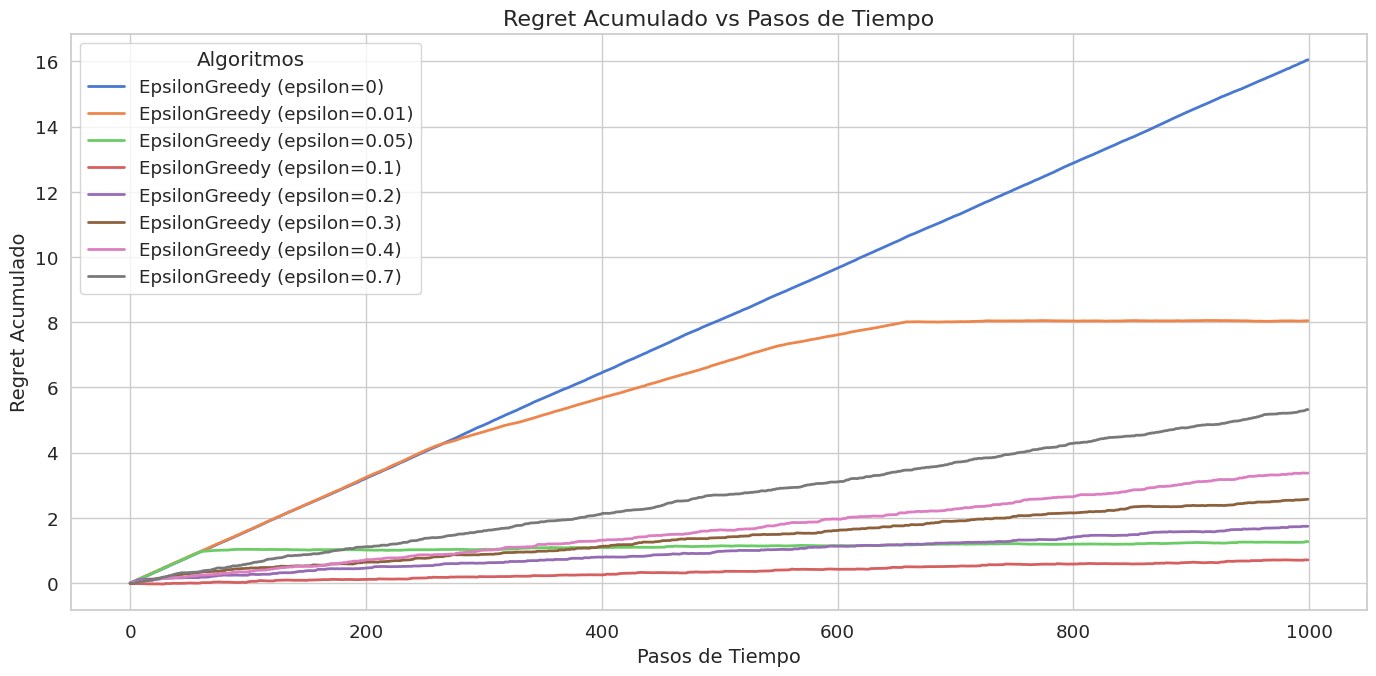

In [ ]:
# theoretical_bound = np.array([np.log(step) for step in steps])

plot_regret(steps, regret_accumulated=proportional_cumulative_regret_per_algo, algorithms = algorithms)

### Análisis detallado de la imagen

Por último, esta imagen muestra un gráfico de líneas titulado **"Regret acumulado vs Pasos de Tiempo"**, donde en el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **regret acumulado** obtenido por cada algoritmo **ε-Greedy** considerado.

**Crecimiento del regret acumulado a lo largo del tiempo:**
  - El algoritmo con **ε=0** (línea **azul**) muestra el peor desempeño, pues el regret crece de forma lineal con el tiempo, y con valores mucho mayores que los otros algoritmos. Esto confirma que seguir una estrategia puramente de explotación, sin nada de exploración, lleva a que el algoritmo se quede atrapado en el primer brazo escogido, que puede no ser el óptimo.
  - El algoritmo con **ε=0.01** (línea **naranja**) muestra un desempeño algo mejor. El regret aumenta al principio, pero después su crecimiento se vuelve más lento conforme el algoritmo encuentra los mejores brazos. Sin embargo, como solo explora en un 1% de los pasos, tarda demasiado en encontrar el mejor brazo.
  - El algoritmo con **ε=0.05** (línea **verde**) tiene un desempeño mejor que los casos anteriores. En los primeros pasos, el regret aumenta algo rápido, pero en poco tiempo consigue estabilizarse, siendo finalmente uno de los algoritmos con regret más bajo.
  - El algoritmo con **ε=0.1** (línea **roja**) muestra el mejor desempeño de entre todos los algoritmos estudiados. Este algoritmo consigue descubrir rápidamente el brazo óptimo, reduciendo las pérdidas por elegir opciones subóptimas.
  - El algoritmo con **ε=0.2** (línea **morada**) comienza con un buen desempeño, con un aumento lento del regret, pues consigue descubrir rápidamente el brazo óptimo, pero a lo largo de tiempo, su desempeño es algo peor que con los anteriores algoritmos, debido a que explora más de lo necesario, en lugar de centrarse en explotar el brazo óptimo una vez lo encuentra.
  - El algoritmo con **ε=0.3** (línea **marrón**) también comienza con un buen desempeño, al descubrir rápidamente el brazo óptimo, pero a lo largo de tiempo, su desempeño se vuelve peor que con los anteriores algoritmos, debido a que explora demasiado después de haber encontrado el mejor brazo.
  - El algoritmo con **ε=0.4** (línea **rosa**) comienza de nuevo con un buen desempeño, con un aumento lento del regret, pero con el paso del tiempo, su desempeño se vuelve considerablemente peor que con algunos de los algoritmos anteriores, pues explora todavía más que los casos anteriores.
  - El algoritmo con **ε=0.7** (línea **gris**) tiene un desempeño claramente peor que muchos de los anteriores algoritmos, debido a que explora un 70% de las veces, incluso después de haber descubierto el brazo óptimo.

## Conclusión

Tras haber realizado el experimento sobre el *problema del bandido de k brazos* comparando el desempeño de distintos algoritmos de la familia *$\varepsilon$-greedy*, y haber representado los distintos gráficos solicitados, hemos podido observar que ciertos gráficos tienen una mayor relevancia. En particular, hemos considerado que el gráfico de **"Regret acumulado vs Pasos de Tiempo"** es el más importante, dado que mide el arrepentimiento o la pérdida acumulada por no elegir el brazo óptimo en cada paso de tiempo. Esta métrica es fundamental porque evalúa la eficiencia de un algoritmo a lo largo del tiempo, pues un regret bajo indica que el algoritmo logra identificar y explotar el brazo óptimo rápidamente, minimizando las pérdidas por exploración de brazos subóptimos.

Por otro lado, hemos considerado conservar también el gráfico de **"Porcentaje de elecciones óptimas vs Pasos de Tiempo"**, dado que este es útil para observar la eficiencia de un algoritmo para identificar y seleccionar el brazo óptimo a lo largo del tiempo, equilibrando eficientemente entre exploración y explotación. Un porcentaje que aumente rápidamente y se mantenga alto a lo largo del tiempo indica que el algoritmo es capaz de identificar y priorizar el brazo óptimo consistentemente. Además, es útil para analizar si el algoritmo mantiene la explotación del mejor brazo con el tiempo, o si sigue explorando innecesariamente. Por tanto, complementa la información del regret mostrando de forma intuitiva la frecuencia con la que se toman las mejores decisiones.

No obstante, hemos decidido descartar los **histogramas con las estadísticas de cada brazo**, ya que la información que proporcionan es muy similar a la del gráfico de "Porcentaje de elecciones óptimas vs Pasos de Tiempo". La principal diferencia es que los histogramas no muestran la evolución de las elecciones a lo largo del tiempo, lo cual consideramos un aspecto importante para analizar el comportamiento de los algoritmos. Si bien los histogramas permiten identificar con exactitud cuáles fueron los brazos seleccionados además del brazo óptimo, no consideramos que esto sea tan relevante como observar cómo evoluciona la selección del brazo óptimo a lo largo del tiempo.

Por último, también hemos decidido que el gráfico de **"Recompensa Promedio vs Pasos de Tiempo"** no es tan relevante para los estudios posteriores, ya que la información que proporciona puede ser redundante y menos informativa en comparación con el porcentaje de elecciones óptimas y el regret. Mientras que la recompensa promedio ofrece una visión más general del desempeño, las otras métricas proporcionan un análisis más detallado sobre la eficiencia y la capacidad de aprendizaje de los algoritmos a lo largo del tiempo.